Deep Neural Network in TensorFlow 2.0

In [46]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

tfd = tfp.distributions


# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0


In [16]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
len(train_labels)

60000

In [6]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

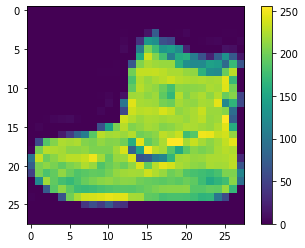

In [7]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [35]:
train_images = tf.cast(train_images, tf.float32) / 255.0

test_images = tf.cast(test_images, tf.float32) / 255.0

In [40]:
train_labels = tf.cast(train_labels, tf.float32)

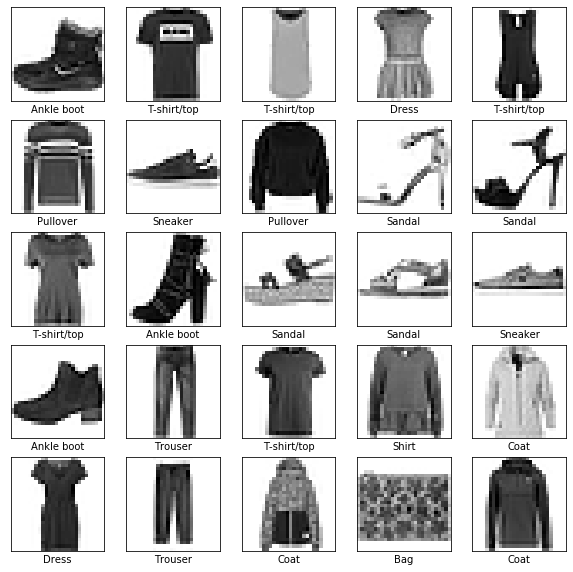

In [36]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [37]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])

In [83]:
logits.numpy()[0]

array([0.10002846, 0.10052429, 0.10001725, 0.09981591, 0.09939258,
       0.09987393, 0.1004967 , 0.09971294, 0.09984503, 0.10029297],
      dtype=float32)

In [80]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax'),
    # tfp.layers.DistributionLambda(lambda t: tfd.Categorical(logits=t[..., :1]))
])

logits = model(train_images)
labels_distribution = tfd.Categorical(logits=logits)

neg_log_likelihood = -tf.reduce_mean(
    input_tensor=labels_distribution.log_prob(train_labels)
)
kl = sum(model.losses) / len(train_images)
elbo_loss = neg_log_likelihood + kl

In [74]:
logits[..., 0]

<tf.Tensor: id=249323, shape=(60000,), dtype=float32, numpy=
array([0.10010209, 0.09997024, 0.0998937 , ..., 0.09996589, 0.09994362,
       0.10017794], dtype=float32)>

In [75]:
logits[...,1]

<tf.Tensor: id=249327, shape=(60000,), dtype=float32, numpy=
array([0.0999289 , 0.09997548, 0.09995655, ..., 0.10016911, 0.09998517,
       0.09992824], dtype=float32)>

In [60]:
optimizer = tf.compat.v1.train.AdamOptimizer(
        learning_rate=0.01)
train_op = optimizer.minimize(elbo_loss)

RuntimeError: `loss` passed to Optimizer.compute_gradients should be a function when eager execution is enabled.

In [58]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_flipout_4 (Conv1DFlip multiple                  1686      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 multiple                  0         
_________________________________________________________________
conv1d_flipout_5 (Conv1DFlip multiple                  976       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 multiple                  0         
_________________________________________________________________
conv1d_flipout_6 (Conv1DFlip multiple                  19320     
_________________________________________________________________
flatten_10 (Flatten)         multiple                  0         
_________________________________________________________________
dense_flipout_6 (DenseFlipou multiple                

In [59]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')


model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=elbo_loss, metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10, verbose=True, callbacks=[PrintDot()]);

ValueError: ('Could not interpret loss function identifier:', <tf.Tensor: id=248105, shape=(), dtype=float32, numpy=5.7964945>)

In [11]:
tfd = tfp.distributions

logits = model(train_images)
labels_distribution = tfd.Categorical(logits=logits)

neg_log_likelihood = -tf.reduce_mean(
      input_tensor=labels_distribution.log_prob(train_labels))
kl = sum(model.losses) / len(train_images)
elbo_loss = neg_log_likelihood + kl

neg_log_likelihood = tf.nn.softmax_cross_entropy_with_logits(
    labels=train_labels.reshape(60000,1), logits=logits)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [12]:
model.compile(optimizer='adam',
              loss=neg_log_likelihood,
              metrics=['accuracy'])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [14]:
model.fit(train_images, train_labels, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 204us/sample - loss: 168323.4939 - accuracy: 0.1143
Epoch 2/10
60000/60000 [==============================] - 11s 186us/sample - loss: 35630.8732 - accuracy: 0.1026
Epoch 3/10
29952/60000 [=============>................] - ETA: 6s - loss: 1863.1484 - accuracy: 0.0982

KeyboardInterrupt: 

In [23]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

10000/1 - 2s - loss: 59.4780 - accuracy: 0.1111

Test accuracy: 0.1111


In [24]:
predictions = model.predict(test_images)

In [25]:
predictions[0]

array([6.4537341e-29, 1.7960127e-12, 1.3956958e-15, 5.5762205e-12,
       3.0324231e-33, 1.0000000e+00, 2.0346216e-34, 8.0753466e-26,
       9.0639433e-29, 7.2181625e-23], dtype=float32)

In [26]:
np.argmax(predictions[0])

5

In [27]:
test_labels[0]

9

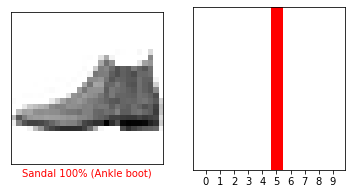

In [29]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

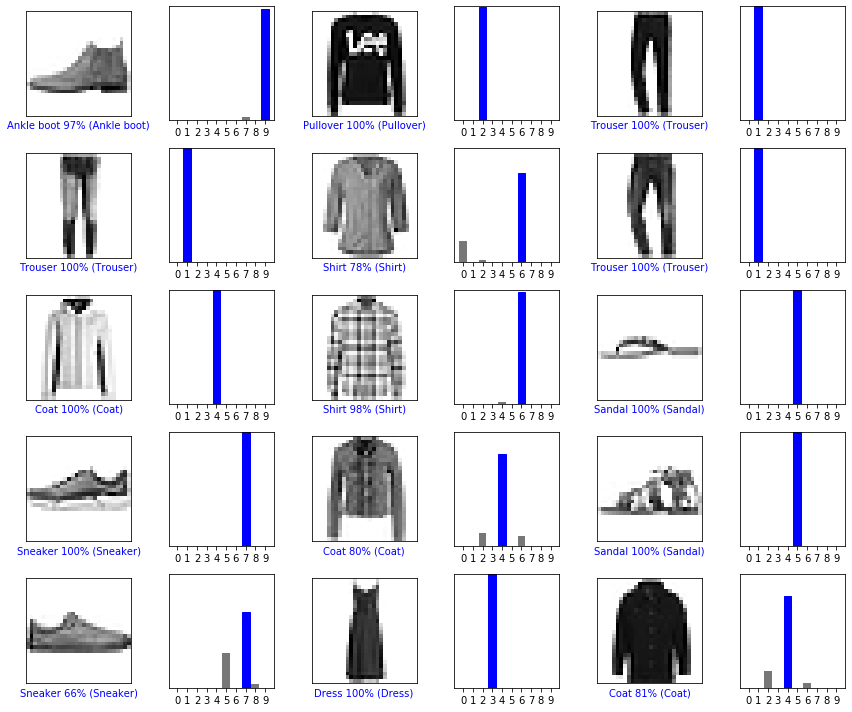

In [21]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

In [24]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(28, 28)


In [25]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [26]:
predictions_single = model.predict(img)

print(predictions_single)

[[3.4860440e-04 2.6555229e-12 9.9595636e-01 1.1445813e-09 3.1907170e-03
  3.9472446e-11 5.0368311e-04 2.0251156e-15 6.4255391e-07 2.0900387e-10]]


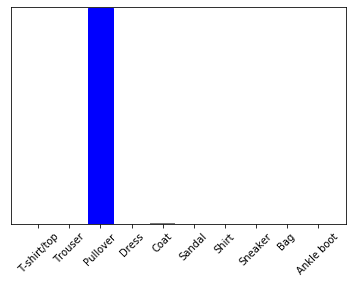

In [27]:
plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [28]:
np.argmax(predictions_single[0])

2

In [11]:
model = tf.keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    tfp.layers.DenseFlipout(512, activation=tf.nn.relu),
    tfp.layers.DenseFlipout(10),
])

logits = model(train_images)

neg_log_likelihood = tf.nn.softmax_cross_entropy_with_logits(
    labels=train_labels.reshape(60000,1), logits=logits)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss = neg_log_likelihood)

logits = model(train_images)
neg_log_likelihood = tf.nn.softmax_cross_entropy_with_logits(
    labels=train_labels.reshape(60000,1), logits=logits)
kl = sum(model.losses)
loss = neg_log_likelihood + kl
train_op = tf.compat.v1.train.AdamOptimizer().minimize(loss)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
tf.train.

In [48]:
logits.shape

TensorShape([60000, 10])

In [51]:
train_labels.reshape(60000,1).shape

(60000, 1)

In [31]:
ten = model(train_images)

In [33]:
ten.shape

TensorShape([60000, 10])

In [38]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [39]:
train_images

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.